In [716]:
"""
! Credit Risk Assessment (Classification)

TODO - Develop a model to predict the credit worthiness of loan applicants based on their financial history and personal information
TODO - Utilize classification algorithms such as Logistic Regression, Decision Trees, or Gradient Boosting Machines
TODO - Evaluate the model's performance using metrics like accuracy, percision, recall, and ROC curve

ID: Unique identifier for each loan applicant.
Age: Age of the loan applicant.
Income: Income of the loan applicant.
Home: Home ownership status (Own, Mortgage, Rent).
Emp_Length: Employment length in years.
Intent: Purpose of the loan (Education, Personal).
Amount: Loan amount applied for.
Rate: Interest rate on the loan.
Status (Target Variable) : Loan approval status.
Percent_Income: Loan amount as a percentage of income.
Default: Whether the applicant has defaulted on a loan previously (Yes, No).
Cred_Length: Length of the applicant's credit history.

"""


"\n! Credit Risk Assessment (Classification)\n\nTODO - Develop a model to predict the credit worthiness of loan applicants based on their financial history and personal information\nTODO - Utilize classification algorithms such as Logistic Regression, Decision Trees, or Gradient Boosting Machines\nTODO - Evaluate the model's performance using metrics like accuracy, percision, recall, and ROC curve\n\nID: Unique identifier for each loan applicant.\nAge: Age of the loan applicant.\nIncome: Income of the loan applicant.\nHome: Home ownership status (Own, Mortgage, Rent).\nEmp_Length: Employment length in years.\nIntent: Purpose of the loan (Education, Personal).\nAmount: Loan amount applied for.\nRate: Interest rate on the loan.\nStatus (Target Variable) : Loan approval status.\nPercent_Income: Loan amount as a percentage of income.\nDefault: Whether the applicant has defaulted on a loan previously (Yes, No).\nCred_Length: Length of the applicant's credit history.\n\n"

## Import Libraries

In [717]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve 
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

## Load dataset

In [718]:
df = pd.read_csv("credit_risk.csv")
print(df.shape)
df.head()

(32581, 12)


,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,Y,3
1,1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
2,2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
3,3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
4,4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4


## Pre-processing

In [719]:
df = df.drop(columns=['Id']) # Remove ID

In [720]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             32581 non-null  int64  
 1   Income          32581 non-null  int64  
 2   Home            32581 non-null  object 
 3   Emp_length      31686 non-null  float64
 4   Intent          32581 non-null  object 
 5   Amount          32581 non-null  int64  
 6   Rate            29465 non-null  float64
 7   Status          32581 non-null  int64  
 8   Percent_income  32581 non-null  float64
 9   Default         32581 non-null  object 
 10  Cred_length     32581 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 2.7+ MB


### Handle missing values

In [721]:
df.isna().sum()

Age                  0
Income               0
Home                 0
Emp_length         895
Intent               0
Amount               0
Rate              3116
Status               0
Percent_income       0
Default              0
Cred_length          0
dtype: int64

In [722]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].apply(lambda x: x.fillna(x.mean()))
df.isna().sum()

Age               0
Income            0
Home              0
Emp_length        0
Intent            0
Amount            0
Rate              0
Status            0
Percent_income    0
Default           0
Cred_length       0
dtype: int64

### Drop duplicates

In [723]:
# Check duplicate data
print("Number of duplicates: " + str(df.duplicated().sum()))

Number of duplicates: 165


In [724]:
df.drop_duplicates(keep=False,inplace=True)

In [725]:
df.describe()

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Cred_length
count,32251.000000,3.225100e+04,32251.000000,32251.000000,32251.000000,32251.000000,32251.000000,32251.000000
mean,27.759542,6.610861e+04,4.791297,9598.365942,11.021823,0.219218,0.170297,5.818455
std,6.360153,6.204835e+04,4.091451,6323.377140,3.084482,0.413723,0.106842,4.063084
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.861600e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,11.011695,0.000000,0.150000,4.000000
75%,30.000000,7.939000e+04,7.000000,12250.000000,13.160000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


### Encoding Categorical variables

In [726]:
# Store original category values before encoding
original_category_values = {}

# Encode categorical variables
label_encoders = {}
categorical_columns = ['Home', 'Intent', 'Default']

for column in categorical_columns:

    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    
    # Display the mapping
    print(f"Mapping for {column}:")
    for class_index, class_label in enumerate(le.classes_):
        print(f"{class_label} -> {class_index}")
    print("\n")
    

df.head()

Mapping for Home:
MORTGAGE -> 0
OTHER -> 1
OWN -> 2
RENT -> 3


Mapping for Intent:
DEBTCONSOLIDATION -> 0
EDUCATION -> 1
HOMEIMPROVEMENT -> 2
MEDICAL -> 3
PERSONAL -> 4
VENTURE -> 5


Mapping for Default:
N -> 0
Y -> 1




,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,22,59000,3,123.0,4,35000,16.02,1,0.59,1,3
1,21,9600,2,5.0,1,1000,11.14,0,0.10,0,2
2,25,9600,0,1.0,3,5500,12.87,1,0.57,0,3
3,23,65500,3,4.0,3,35000,15.23,1,0.53,0,2
4,24,54400,3,8.0,3,35000,14.27,1,0.55,1,4


### Outliers

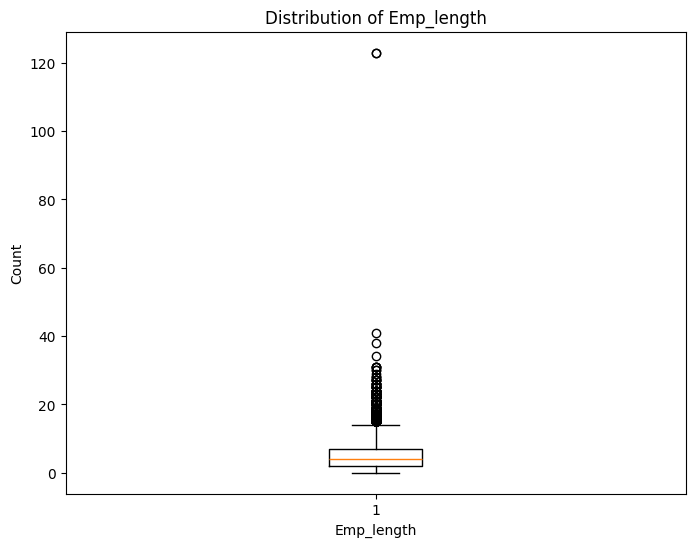

In [727]:
# Set the figure size
plt.figure(figsize=(8, 6))

plt.boxplot(df.Emp_length)
plt.xlabel("Emp_length")
plt.ylabel("Count")
plt.title("Distribution of Emp_length")
plt.show()

In [728]:
df.Emp_length.describe()

count    32251.000000
mean         4.791297
std          4.091451
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: Emp_length, dtype: float64

In [729]:
# Function to remove outliers using Z-score
def remove_outliers_zscore(df, column, threshold=5):
    z_scores = zscore(df[column])
    df = df[(np.abs(z_scores) <= threshold)]
    return df

# Remove outliers from the 'Emp_Length' column
df = remove_outliers_zscore(df, 'Emp_length')
df

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
1,21,9600,2,5.0,1,1000,11.14,0,0.10,0,2
2,25,9600,0,1.0,3,5500,12.87,1,0.57,0,3
3,23,65500,3,4.0,3,35000,15.23,1,0.53,0,2
4,24,54400,3,8.0,3,35000,14.27,1,0.55,1,4
5,21,9900,2,2.0,5,2500,7.14,1,0.25,0,2
...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,0,1.0,4,5800,13.16,0,0.11,0,30
32577,54,120000,0,4.0,4,17625,7.49,0,0.15,0,19
32578,65,76000,3,3.0,2,35000,10.99,1,0.46,0,28
32579,56,150000,0,5.0,4,15000,11.48,0,0.10,0,26


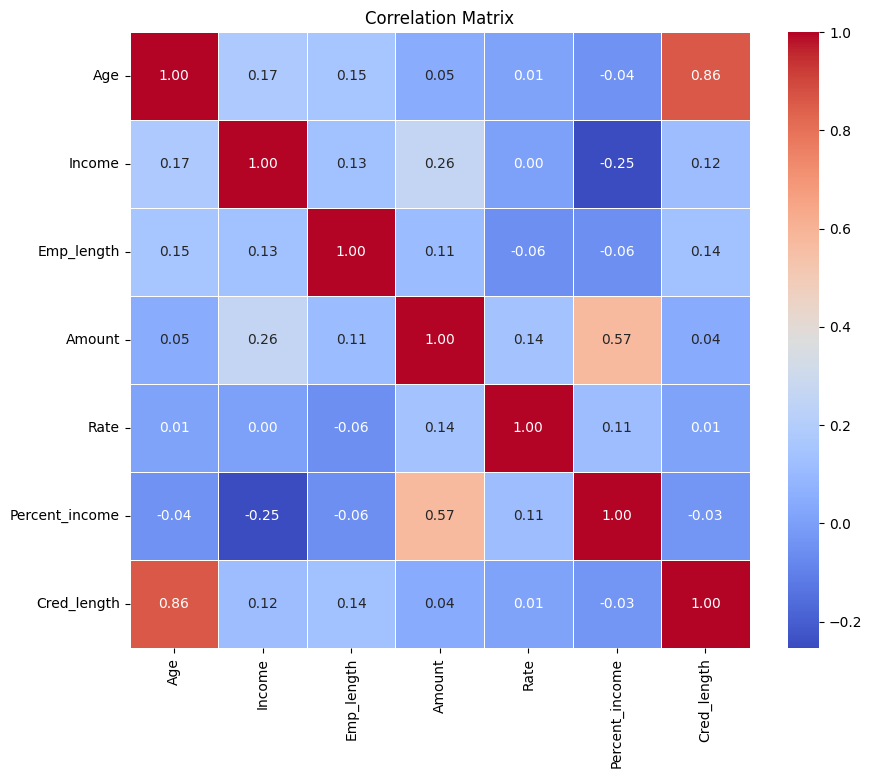

In [730]:
# Select numerical features for correlation analysis
numerical_features = ['Age', 'Income', 'Emp_length', 'Amount', 'Rate', 'Percent_income', 'Cred_length']

# Calculate the correlation matrix
correlation_matrix = df[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Split Data into Features and Target

In [731]:
# Split the dataset into features and target
X = df.drop(['Status'], axis=1)
y = df['Status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Training

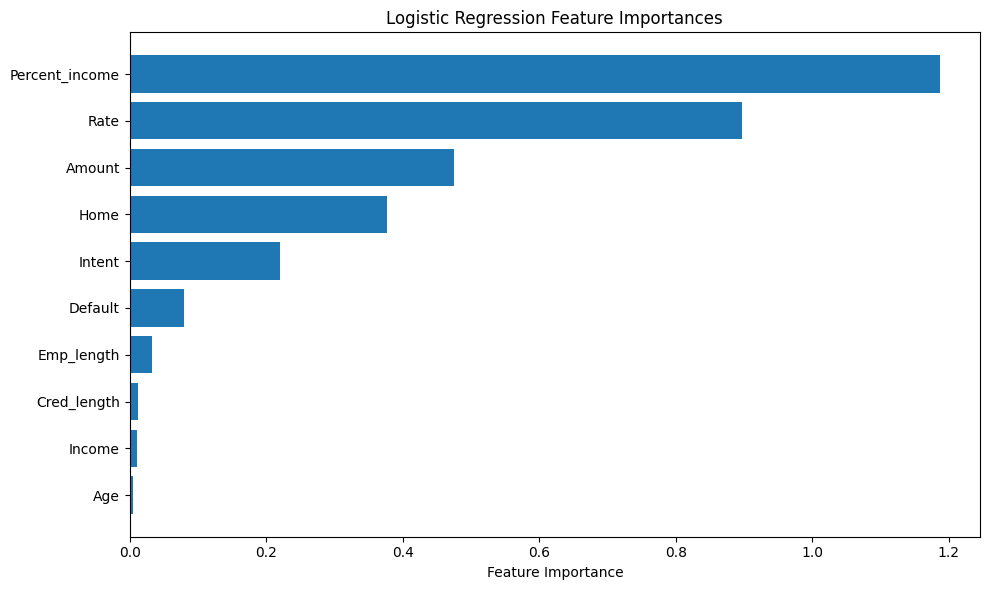

In [732]:
# Logistic Regression
lr_model = LogisticRegression(random_state=12)
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)

coefficients = lr_model.coef_[0]
feature_names = X.columns
feature_importances = np.abs(coefficients)  

sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Logistic Regression Feature Importances")
plt.tight_layout()
plt.show()

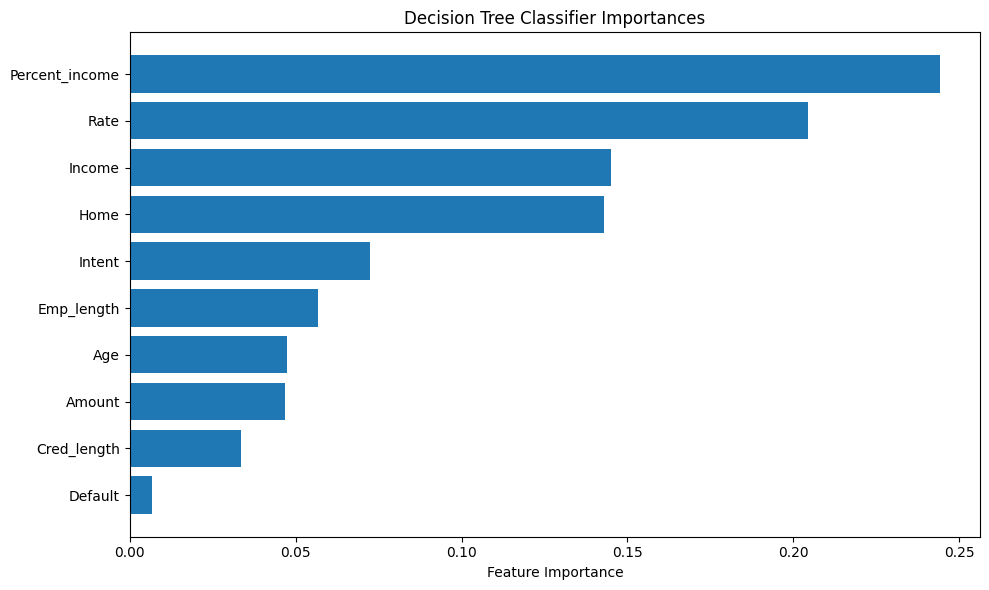

In [733]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=12)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

feature_importances = dt_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Decision Tree Classifier Importances")
plt.tight_layout()
plt.show()

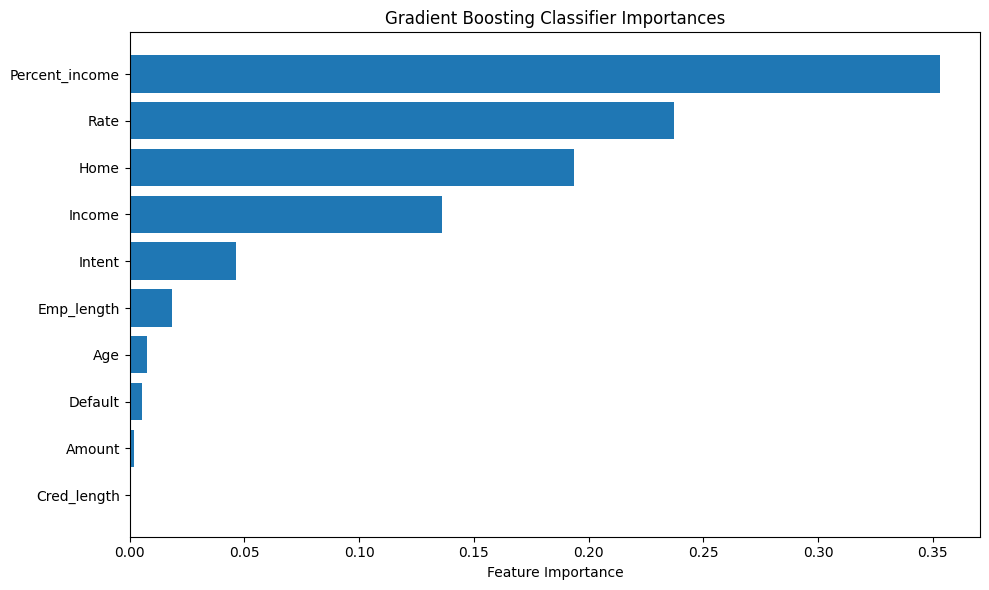

In [734]:
# Gradient Boosting Classifier
gbc_model = GradientBoostingClassifier(random_state=12)
gbc_model.fit(X_train, y_train)

y_pred_gbc = gbc_model.predict(X_test)


feature_importances = gbc_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting Classifier Importances")
plt.tight_layout()
plt.show()

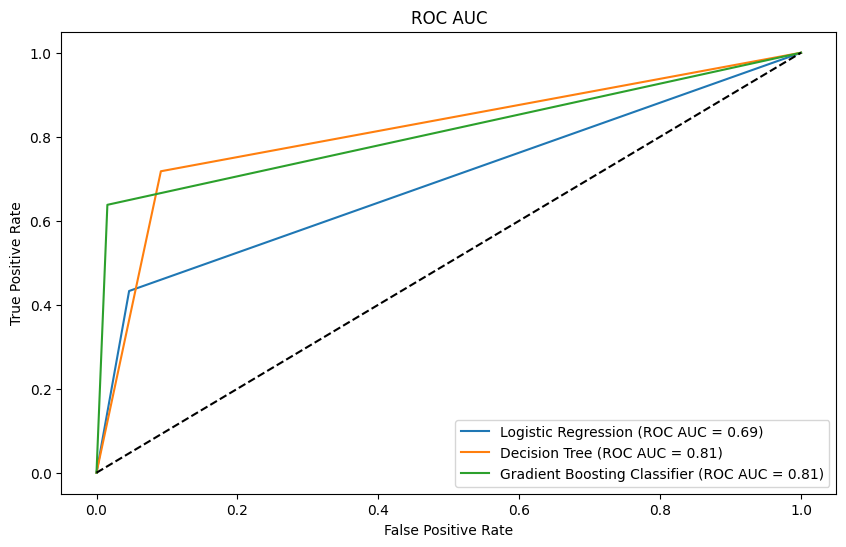

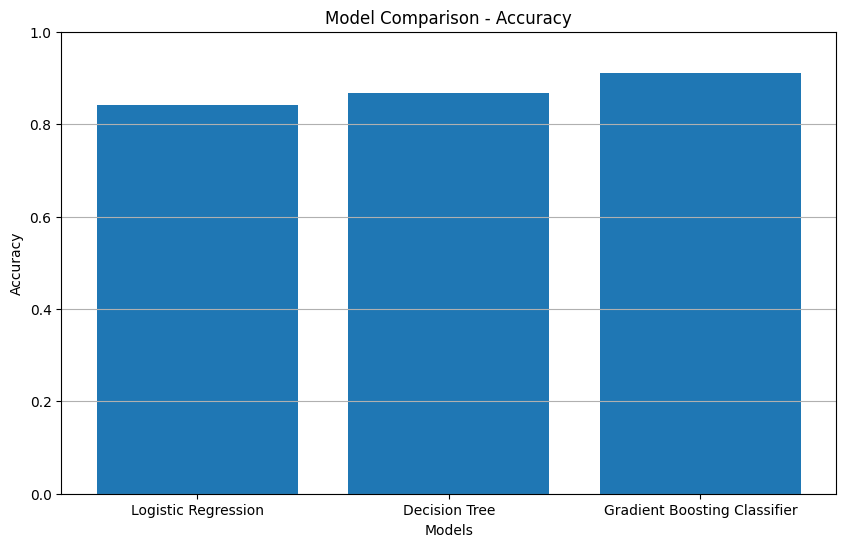

Logistic Regression:
Accuracy: 0.84
Precision: 0.72
Recall: 0.43
F1 Score: 0.54
ROC AUC: 0.69

Decision Tree:
Accuracy: 0.87
Precision: 0.68
Recall: 0.72
F1 Score: 0.70
ROC AUC: 0.81

Gradient Boosting Classifier:
Accuracy: 0.91
Precision: 0.92
Recall: 0.64
F1 Score: 0.75
ROC AUC: 0.81



In [735]:
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    
    return accuracy, precision, recall, f1, roc_auc, fpr, tpr
# Evaluate models and collect evaluation metrics
metrics = {}

metrics['Logistic Regression'] = evaluate_model(y_test, y_pred_lr)
metrics['Decision Tree'] = evaluate_model(y_test, y_pred_dt)
metrics['Gradient Boosting Classifier'] = evaluate_model(y_test, y_pred_gbc)

# Plot ROC AUC
plt.figure(figsize=(10, 6))

for model, (accuracy, precision, recall, f1, roc_auc, fpr, tpr) in metrics.items():
    plt.plot(fpr, tpr, label=f'{model} (ROC AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend(loc='lower right')
plt.show()

# Plot accuracy for each model
accuracies = {model: metrics[model][0] for model in metrics} 
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Model Comparison - Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming the accuracy scores are between 0 and 1
plt.grid(axis='y')
plt.show()

# Print the evaluation metrics
for model, (accuracy, precision, recall, f1, roc_auc, _, _) in metrics.items():
    print(f'{model}:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'ROC AUC: {roc_auc:.2f}')
    print()